# Introduction/Abstract

Placeholder
- Political Landscape of Arizona?
- What we are doing? Etc.

# Data Wrangling

Data often starts messy and this is no different from this data set that we are using. We wish to look at how we can effectively make our data better so we can perform unbiased and more accurate analysis, providing a better result and conclusion. Below are steps that we will take to make that process smooth before we dive into data exploration.

We will go through the following steps in this short section:

- About the data
    - Selecting Inital Variables
- About the process
    - Reading in the Data
    - Selection of Variable (Code)
- Looking at Missing Data
    - Dropping Columns
    - Dropping Rows
- Imputation of Missing Variables
    - Imputation for Continous Random Variables
    - Imputation for Categorical Random Variables

## About the Data

The data used in this project utilizes the VM2 Uniform Dataset from L2 Voter Files made available by University of Pennsylvania. It contains extensive demographic and voting history details of registered voters in the United States. In this portion specficifically, we go through our methodologies of extracting and cleaning the data for better use for our analysis in future sections.

### Selecting the Variable

Below is our first initial selection on the range of variables we should consider. There were 726 possible selections and our team narrowed it down to 24 predictors with 1 key. 

The variables were selected to capture a wide range of demographic information while avoiding highly correlated information to reduce possibility of overfitting in our machine learning models later in this report.

*The variables are divided into 6 key sections outlined below:*

**Demographic Information:**
- LALVOTERID
- Voters_Gender
- Voters_Age
- Ethnic_Description
- Voters_PlaceOfBirth

**Geographic Information:**

- Voters_FIPS
- CountyEthnic_LALEthnicCode
- CountyEthnic_Description

**Political Information:**

- Parties_Description
- Voters_VotingPerformanceEvenYearGeneral

**Economic Information:**

- Mailing_Families_HHCount
- CommercialData_Education
- CommercialData_EstimatedHHIncome
- CommercialData_EstimatedAreaMedianHHIncome
- CommercialData_AreaPcntHHMarriedCoupleWithChild
- CommercialData_AreaPcntHHSpanishSpeaking
- CommercialData_AreaMedianEducationYears
- CommercialData_PoliticalContributerInHome
- CommercialDataLL_Hispanic_Country_Origin

**Voting Behavior:**

- Vote_By_Mail_Area

**Election Results:**

- ElectionReturns_G16_Cnty_Vote_Clinton_D
- ElectionReturns_G16_Cnty_Vote_Trump_R
- ElectionReturns_G12_Cnty_Vote_Obama_D
- ElectionReturns_G12_Cnty_Vote_Romney_R
- ElectionReturns_G08_Cnty_Vote_Obama_D
- ElectionReturns_G08_Cnty_Vote_McCain_R

## About the Process
The data itself is stored as parquet files in a designated Google Cloud bucket.  Utilizing Google Cloud Shell, we pull from this repository, targeting specfically Arizona state data for further analyiss. Our team utilizes Google Cloud's Dataproc clusters to take advantage of its high scalability functions for large data and its steamless integration with Apache Spark. This allows us to leverage advanced analytics and machine learning capabilities for big data.

### Reading in the Data

In the section below, data is read from a Google Cloud Storage bucket through PySpark library.

In [209]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import numpy as np

spark = SparkSession \
.builder \
.appName("Read Voter File Data") \
.config("spark.sql.debug.maxToStringFields", 100) \
.getOrCreate()
df = (
spark.read
.format("parquet")
.option("header", "true")
.option("inferSchema", "true")
.load("gs://winter-2024-voter-file/VM2Uniform/VM2Uniform--AZ--2021-05-20")
)

### Selection of Variables through Code
Here we outline the code for selection of variables for a PySpark dataframe in Python.

In [210]:
selected_df = df.select(
    "LALVOTERID",
    "Voters_Gender",
    "Voters_Age",
    "Ethnic_Description",
    "Voters_PlaceOfBirth",
    "Voters_FIPS",
    "CountyEthnic_LALEthnicCode",
    "CountyEthnic_Description",
    "Parties_Description",
    "Voters_VotingPerformanceEvenYearGeneral",
    "Mailing_Families_HHCount",
    "CommercialData_Education",
    "CommercialData_EstimatedHHIncome",
    "CommercialData_EstimatedAreaMedianHHIncome",
    "CommercialData_AreaPcntHHMarriedCoupleWithChild",
    "CommercialData_AreaPcntHHSpanishSpeaking",
    "CommercialData_AreaMedianEducationYears",
    "CommercialData_PoliticalContributerInHome",
    "CommercialDataLL_Hispanic_Country_Origin",
    "Vote_By_Mail_Area",
    "ElectionReturns_G16_Cnty_Vote_Clinton_D",
    "ElectionReturns_G16_Cnty_Vote_Trump_R",
    "ElectionReturns_G12_Cnty_Vote_Obama_D",
    "ElectionReturns_G12_Cnty_Vote_Romney_R",
    "ElectionReturns_G08_Cnty_Vote_McCain_R",
    "ElectionReturns_G08_Cnty_Vote_Obama_D",
    "ElectionReturns_G08CountyTurnoutAllRegisteredVoters",
    "ElectionReturns_G08CountyTurnoutDemocrats",
    "ElectionReturns_G08CountyTurnoutIndependentsAllOthers",
    "ElectionReturns_G08CountyTurnoutRepublicans",
    "ElectionReturns_G12CountyTurnoutAllRegisteredVoters",
    "ElectionReturns_G12CountyTurnoutDemocrats",
    "ElectionReturns_G12CountyTurnoutIndependentsAllOthers",
    "ElectionReturns_G12CountyTurnoutRepublicans",
    "ElectionReturns_G16CountyTurnoutAllRegisteredVoters",
    "ElectionReturns_G16CountyTurnoutDemocrats",
    "ElectionReturns_G16CountyTurnoutIndependentsAllOthers",
    "ElectionReturns_G16CountyTurnoutRepublicans"
)

## Looking at the Missing Data

Below, we look at missing data per each column to understand which variables or rows for better analysis and preparation of modeling.

In [211]:
#This is a function that calculates count and percentage of missing data

def calc_null_percent(spark_df, sort=True):
    
    final_df = spark_df.select([
        F.sum(F.when(F.isnan(c) | F.isnull(c), 1).otherwise(0)).alias(c)
        for c in spark_df.columns
    ]).toPandas().T.reset_index().rename(columns={0: 'null_count', 'index': 'column'})
    
    final_df['null_percentage'] = final_df['null_count'] * 100 / 4266400

    if len(final_df) == 0:
        print("There are no any missing values!")
        return None

    return final_df

nullStatsDF = spark.createDataFrame(calc_null_percent(selected_df))

nullStatsPandasDF = nullStatsDF.toPandas()

nullStatsPandasDF.head(30)

,column,null_count,null_percentage
0,LALVOTERID,0,0.000000
1,Voters_Gender,22819,0.534854
2,Voters_Age,3118,0.073083
3,Ethnic_Description,411429,9.643470
4,Voters_PlaceOfBirth,3769356,88.349803
5,Voters_FIPS,0,0.000000
6,CountyEthnic_LALEthnicCode,4266400,100.000000
7,CountyEthnic_Description,4266400,100.000000
8,Parties_Description,0,0.000000
9,Voters_VotingPerformanceEvenYearGeneral,0,0.000000


#### Graphical Representation
Below is a graph that clearly visualizes percentage of missing values per each column. 

**Note:** the graph does not display any columns that has no missing observations.

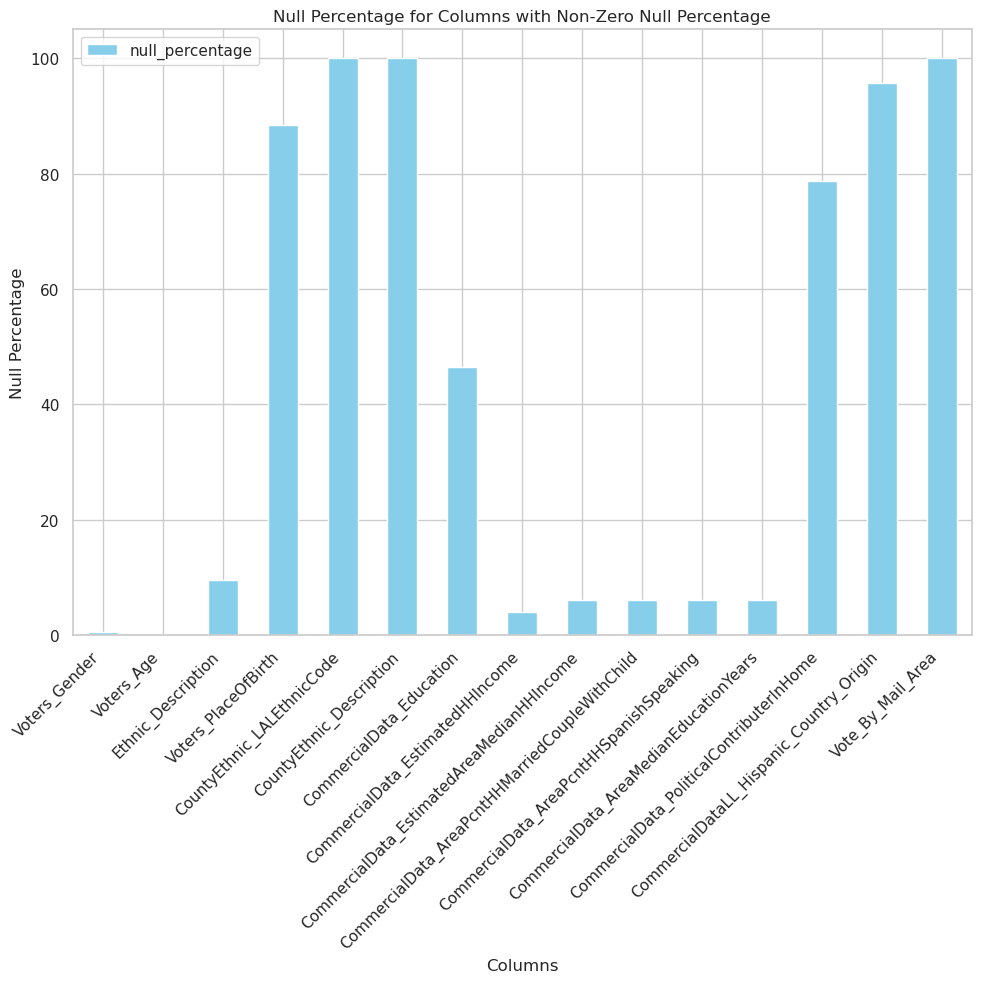

In [212]:
import matplotlib.pyplot as plt

# Filter out columns with non-zero null percentages
non_zero_null_percent_cols = nullStatsPandasDF[nullStatsPandasDF['null_percentage'] > 0]

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
non_zero_null_percent_cols.plot(kind='bar', x='column', y='null_percentage', ax=ax, color='skyblue')

# Adding labels and title
plt.xlabel('Columns')
plt.ylabel('Null Percentage')
plt.title('Null Percentage for Columns with Non-Zero Null Percentage')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()

Notice above from both table and graph that these are problematic variables:
- Vote_By_Mail_Area
- CountyEthnic_LALEthnicCode
- CountyEthnic_Description
- CommercialDataLL_Hispanic_Country_Origin
- Voters_PlaceOfBirth
- CommercialData_PoliticalContributerInHome
- CommercialData_Education

### Dropping Data
From the analysis above, we can deduce that there are columns and variables that must be dropped to ensure that our machine learning models are robust and practical. 

#### Dropping Columns

The obvious variables to drop are those that have more than 70% of its data missing. This includes:
- Voters_PlaceOfBirth
- CountyEthnic_LALEthnicCode
- CountyEthnic_Description
- CommericalDataLL_Hispanic_Country_Origin
- Vote_By_Mail_Area
- CommercialData_PoliticalContributerInHome

The next less obvious variable that we must drop is:
- CommercialData_Education

Although CommercialData_Education is an important demographic factor, it simply has too many missing observations to include as a variable for our machine learning model. With 46% of its observations are missing, it is difficult to perform data imputation without heavily skewing results from the actual data itself. Thus, we drop the entire column rather than rows to preserve observations for our other variables.

##### Dropping Columns in Python
Below we drop the columns from our PySpark dataframe in Python

In [213]:
# Columns to drop
columns_to_drop = [
    "Voters_PlaceOfBirth",
    "CountyEthnic_LALEthnicCode",
    "CountyEthnic_Description",
    "CommercialDataLL_Hispanic_Country_Origin",
    "Vote_By_Mail_Area",
    "CommercialData_PoliticalContributerInHome",
    "CommercialData_Education"
]

# Drop columns from the DataFrame
cleaned_df = selected_df.drop(*columns_to_drop)

And we are left with the remaining 16 variables and 1 unique identifier for rows of observations.

In [214]:
num_variables = len(cleaned_df.columns)
print("Number of Remaining Variables:", num_variables)
print()
remaining_variables = cleaned_df.columns
for var in remaining_variables:
    print(var)

Number of Remaining Variables: 31

LALVOTERID
Voters_Gender
Voters_Age
Ethnic_Description
Voters_FIPS
Parties_Description
Voters_VotingPerformanceEvenYearGeneral
Mailing_Families_HHCount
CommercialData_EstimatedHHIncome
CommercialData_EstimatedAreaMedianHHIncome
CommercialData_AreaPcntHHMarriedCoupleWithChild
CommercialData_AreaPcntHHSpanishSpeaking
CommercialData_AreaMedianEducationYears
ElectionReturns_G16_Cnty_Vote_Clinton_D
ElectionReturns_G16_Cnty_Vote_Trump_R
ElectionReturns_G12_Cnty_Vote_Obama_D
ElectionReturns_G12_Cnty_Vote_Romney_R
ElectionReturns_G08_Cnty_Vote_McCain_R
ElectionReturns_G08_Cnty_Vote_Obama_D
ElectionReturns_G08CountyTurnoutAllRegisteredVoters
ElectionReturns_G08CountyTurnoutDemocrats
ElectionReturns_G08CountyTurnoutIndependentsAllOthers
ElectionReturns_G08CountyTurnoutRepublicans
ElectionReturns_G12CountyTurnoutAllRegisteredVoters
ElectionReturns_G12CountyTurnoutDemocrats
ElectionReturns_G12CountyTurnoutIndependentsAllOthers
ElectionReturns_G12CountyTurnoutRepu

#### Table of Null Percentage after Dropping Columns

In [215]:
def calc_null_percent(spark_df, sort=True):
    
    final_df = spark_df.select([
        F.sum(F.when(F.isnan(c) | F.isnull(c), 1).otherwise(0)).alias(c)
        for c in spark_df.columns
    ]).toPandas().T.reset_index().rename(columns={0: 'null_count', 'index': 'column'})
    
    final_df['null_percentage'] = final_df['null_count'] * 100 / 4266400

    if len(final_df) == 0:
        print("There are no any missing values!")
        return None

    return final_df

nullStatsDF = spark.createDataFrame(calc_null_percent(cleaned_df))

nullStatsPandasDF = nullStatsDF.toPandas()

nullStatsPandasDF.head(30)

,column,null_count,null_percentage
0,LALVOTERID,0,0.000000
1,Voters_Gender,22819,0.534854
2,Voters_Age,3118,0.073083
3,Ethnic_Description,411429,9.643470
4,Voters_FIPS,0,0.000000
5,Parties_Description,0,0.000000
6,Voters_VotingPerformanceEvenYearGeneral,0,0.000000
7,Mailing_Families_HHCount,0,0.000000
8,CommercialData_EstimatedHHIncome,172331,4.039260
9,CommercialData_EstimatedAreaMedianHHIncome,264576,6.201388


### Dropping Rows

From the above, we see that interestingly enough, the following four variables have the exact same null_percentage:

- CommercialData_EstimatedAreaMedianHHIncome
- CommercialData_AreaPcntHHMarriedCoupleWithChild
- CommercialData_AreaPcntHHSpanishSpeaking
- CommercialData_AreaMedianEducationYears

Here below, we verify that this result is no coincidence. A missing observation for one of these variables implies that all four variables have a missing observation.

In [216]:
from pyspark.sql.functions import col

columns_to_check = [
    "CommercialData_EstimatedAreaMedianHHIncome",
    "CommercialData_AreaPcntHHMarriedCoupleWithChild",
    "CommercialData_AreaPcntHHSpanishSpeaking",
    "CommercialData_AreaMedianEducationYears"
]

# Filter the DataFrame to count rows where all specified columns have missing values
rows_with_missing = cleaned_df.filter(
    (col("CommercialData_EstimatedAreaMedianHHIncome").isNull()) &
    (col("CommercialData_AreaPcntHHMarriedCoupleWithChild").isNull()) &
    (col("CommercialData_AreaPcntHHSpanishSpeaking").isNull()) &
    (col("CommercialData_AreaMedianEducationYears").isNull())
)

# Count the number of rows with missing values in all specified columns
num_rows_with_missing = rows_with_missing.count()

print("Number of rows with missing values in all specified columns:", num_rows_with_missing)

Number of rows with missing values in all specified columns: 264576


These rows with missing observations represents a voter which we have poor collection of data on. They contain too many null values to properly assess their behavior. Since our data set is relatively large, it is safe to drop these rows where information capture is poor. Thus, we drop rows where these observations are missing.

#### Dropping Rows in Python

Below we drop the rows in our PySpark Data Frame that has missing observations in the columns above.

In [217]:
cleaned_df = cleaned_df.dropna(subset=[
    "CommercialData_EstimatedAreaMedianHHIncome",
    "CommercialData_AreaPcntHHMarriedCoupleWithChild",
    "CommercialData_AreaPcntHHSpanishSpeaking",
    "CommercialData_AreaMedianEducationYears"
])

#### Table of Null Percentage after Dropping Rows

In [218]:
def calc_null_percent(spark_df, sort=True):
    
    final_df = spark_df.select([
        F.sum(F.when(F.isnan(c) | F.isnull(c), 1).otherwise(0)).alias(c)
        for c in spark_df.columns
    ]).toPandas().T.reset_index().rename(columns={0: 'null_count', 'index': 'column'})
    
    final_df['null_percentage'] = final_df['null_count'] * 100 / 4266400

    if len(final_df) == 0:
        print("There are no any missing values!")
        return None

    return final_df

nullStatsDF = spark.createDataFrame(calc_null_percent(cleaned_df))

nullStatsPandasDF = nullStatsDF.toPandas()

nullStatsPandasDF.head(30)

,column,null_count,null_percentage
0,LALVOTERID,0,0.000000
1,Voters_Gender,20453,0.479397
2,Voters_Age,2719,0.063731
3,Ethnic_Description,371625,8.710505
4,Voters_FIPS,0,0.000000
5,Parties_Description,0,0.000000
6,Voters_VotingPerformanceEvenYearGeneral,0,0.000000
7,Mailing_Families_HHCount,0,0.000000
8,CommercialData_EstimatedHHIncome,817,0.019150
9,CommercialData_EstimatedAreaMedianHHIncome,0,0.000000


Our method has nicely prepared us a much cleaner data set to train our machine learning models on. Furthermore, it reduces the need to do complex and technical imputation as we remain with variables that have very low % of missing data. 

This compromise of more complex statistical techinques has largely improved our ability to explain data to a more general audience. These two removal methods also are easy to interpret as they prove to be natural and allow for the rest of our analysis to be much more interpretable. 

## Imputation of Missing Variables

Here we look at the remaining missing variables and decide how we wish to impute missing data. We seperate this portion into two categories. 

- Continuous 
- Categorical 

### Imputation for Continous Variables

There is only one continous variables for which we will need to peform imputation on.

- Voters_Age

Let's look at the distribution graph understand the best way to impute data.

**Voter's Age Density Graph** 

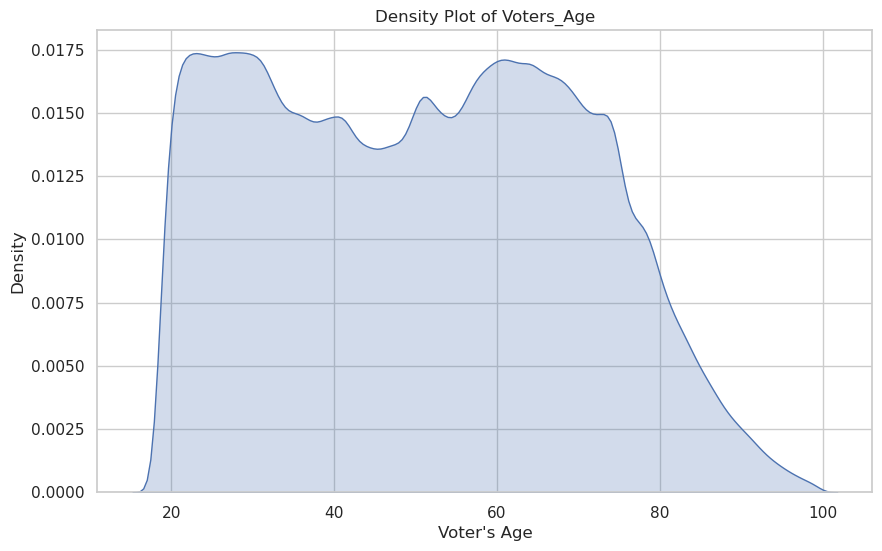

In [219]:
import seaborn as sns

# Filter out null values in Voters_Age column and cast it to integer
age_data = cleaned_df.select("Voters_Age").dropna()
age_data = age_data.withColumn("Voters_Age", col("Voters_Age").cast("integer"))

# Convert Spark DataFrame to Pandas DataFrame
age_data_pd = age_data.toPandas()

# Plotting the density graph using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.kdeplot(data=age_data_pd["Voters_Age"], shade=True)
plt.title("Density Plot of Voters_Age")
plt.xlabel("Voter's Age")
plt.ylabel("Density")
plt.show()

From the above, we have a bimodal distribution where a randomly chosen voter is most likely going to be in their 20-30s or 60-70s. We wish to impute values that would preturb as little of the above distribution as possible. 

Since the distribution is heavy-tailed, we do not wish to use the mean as it will be skewed. However, notice how the distribution is uniform - thus to maintain robustness, the median should be used to impute missing values for age.

**Imputing Median using PySpark** Below, we use PySpark.ml library to utilize the Imputer function to impute median for missing Voter's Age.

In [220]:
from pyspark.ml.feature import Imputer

cleaned_df = cleaned_df.withColumn("Voters_Age", col("Voters_Age").cast("integer"))

imputer = Imputer(
    inputCols=["Voters_Age"], 
    outputCols=["Voters_Age_Impute"]
    ).setStrategy("median")

# Add imputation cols to df
cleaned_df = imputer.fit(cleaned_df).transform(cleaned_df)

**Voter's Age Imputed Density Graph** 
Below we look at the density graph after we imputed missing values. As the graph depicts below, we did not majorly perturb the shape or density of the distribution before imputation of missing values.

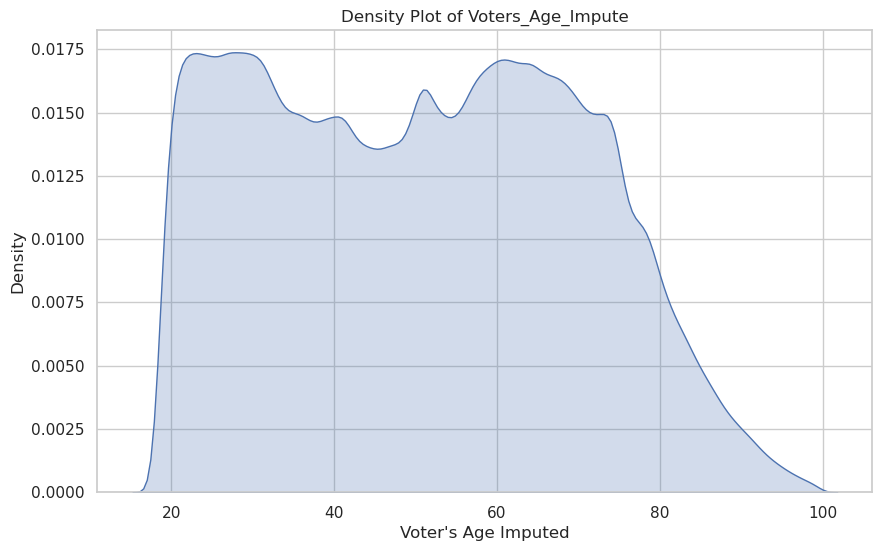

In [221]:
import seaborn as sns

# Filter out null values in Voters_Age column and cast it to integer
age_data = cleaned_df.select("Voters_Age_Impute").dropna()
age_data = age_data.withColumn("Voters_Age_Impute", col("Voters_Age_Impute").cast("integer"))

# Convert Spark DataFrame to Pandas DataFrame
age_data_pd = age_data.toPandas()

# Plotting the density graph using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.kdeplot(data=age_data_pd["Voters_Age_Impute"], shade=True)
plt.title("Density Plot of Voters_Age_Impute")
plt.xlabel("Voter's Age Imputed")
plt.ylabel("Density")
plt.show()

**Dropping the original Column** As our imputation for missing values went well, we drop the original column with missing values and keep the new column with imputed median values for missing data.

In [222]:
cleaned_df = cleaned_df.drop('Voters_Age')

### Imputation for Categorical Variables

We have 3 categorical variables for which we must consider imputation for:

- Voters_Gender
- Ethnic_Description
- CommercialData_EstimatedHHIncome

To do imputation for Categorical Variables, we must look at the count density of their respective discrete categories.

**Density Graph for Voter's Gender**

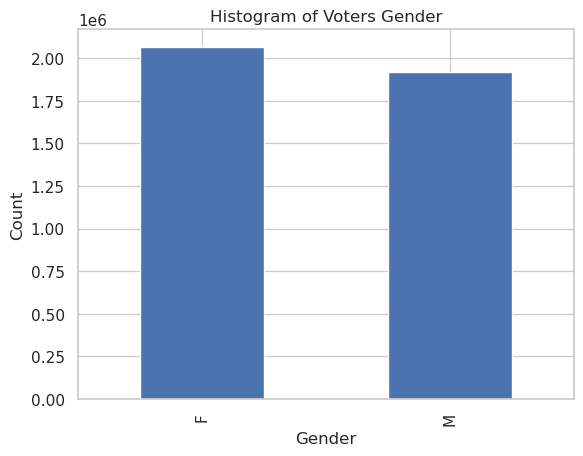

In [223]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = cleaned_df.select('Voters_Gender').toPandas()

# Count occurrences of each category
gender_counts = pandas_df['Voters_Gender'].value_counts()

# Plot histogram
gender_counts.plot(kind='bar', title='Histogram of Voters Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

To decide how to impute the whether a voter should be male or female, we can look at the proportion of voters who are of one Gender. In this case, we can look at what proportion of Voters are female.

In [224]:
# Calculate the total count of rows
total_count = cleaned_df.count()

# Calculate the count of rows where the column equals the target value
target_count = cleaned_df.filter(col("Voters_Gender") == "Female").count()

# Calculate the percentage
percentage = (target_count / total_count) * 100

#print out percentage
print(percentage)

0.0


**Impute missing values based on percentage above**

Based on the above proportions, we impute missing values based on the population that is representative of our data.

In [225]:
cleaned_df = df.withColumn("Voters_Gender", 
                          F.when(col("Voters_Gender").isNull(), 
                              F.when(F.rand() <= percentage, "F").otherwise("M")
                              ).otherwise(col("Voters_Gender"))
                         )

**Density Graph for Estimated House Hold Income**

We do something similar for Estimated House Hold Income.

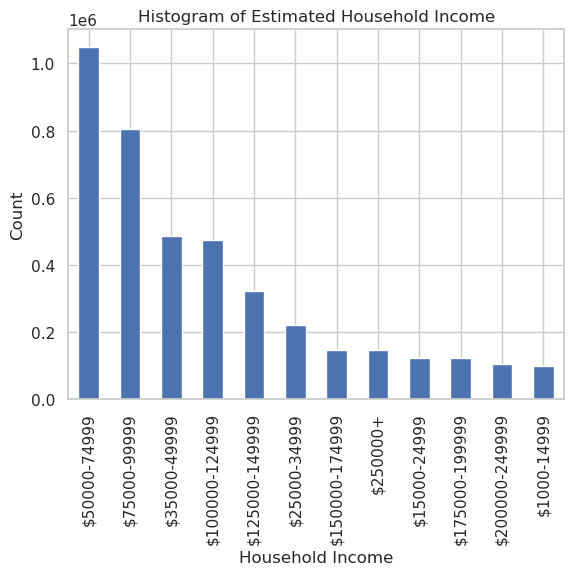

In [226]:
import pandas as pd
import numpy as np

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = cleaned_df.select('CommercialData_EstimatedHHIncome').toPandas()

# Count occurrences of each category
gender_counts = pandas_df['CommercialData_EstimatedHHIncome'].value_counts()

# Plot histogram
gender_counts.plot(kind='bar', title='Histogram of Estimated Household Income')
plt.xlabel('Household Income')
plt.ylabel('Count')
plt.show()

Below, we grab the proportions for each category. In total, there are 13 levels of estimated household income.

In [227]:
category_proportions = cleaned_df.groupBy("CommercialData_EstimatedHHIncome") \
                         .count() \
                         .withColumn("proportion", F.col("count") / df.count()) \
                         .select("CommercialData_EstimatedHHIncome", "proportion") \
                         .collect()

# Convert the proportions to a list of tuples
proportions_list = [(row["CommercialData_EstimatedHHIncome"], row["proportion"]) for row in category_proportions]

print(proportions_list)

[('$175000-199999', 0.028470138758672416), ('$250000+', 0.03404251828239265), ('$1000-14999', 0.022957762985186574), ('$100000-124999', 0.11088153947121696), ('$75000-99999', 0.1885142040127508), (None, 0.040392602662666414), ('$125000-149999', 0.07541627601725108), ('$25000-34999', 0.05155259703731483), ('$200000-249999', 0.024710763172698293), ('$50000-74999', 0.2459131820738796), ('$150000-174999', 0.03420916932308269), ('$35000-49999', 0.11406431651978248), ('$15000-24999', 0.028874929683105195)]


However, to generate a proper representation of the sample, we first need to transform the above results into cumulative sums. The below code accomplishes this.

In [228]:
cumulative_proportions = []
cumulative_sum = 0
for category, proportion in proportions_list:
    cumulative_sum += proportion
    cumulative_proportions.append((category, cumulative_sum))

print(cumulative_proportions)

[('$175000-199999', 0.028470138758672416), ('$250000+', 0.06251265704106507), ('$1000-14999', 0.08547042002625165), ('$100000-124999', 0.1963519594974686), ('$75000-99999', 0.3848661635102194), (None, 0.4252587661728858), ('$125000-149999', 0.5006750421901369), ('$25000-34999', 0.5522276392274518), ('$200000-249999', 0.57693840240015), ('$50000-74999', 0.8228515844740296), ('$150000-174999', 0.8570607537971123), ('$35000-49999', 0.9711250703168948), ('$15000-24999', 1.0)]


Now, we can generate a uniform sample that decides how a particular voter would be classified. This sampling should be indicative of the actual distribution as it follows the CDF of our population from above.

In [229]:
from pyspark.sql.functions import when, col, rand

cleaned_df = cleaned_df.withColumn("CommercialData_EstimatedHHIncome", 
                          when(col("CommercialData_EstimatedHHIncome").isNull(), 
                               when(rand() <= cumulative_proportions[0][1], cumulative_proportions[0][0])
                               .when(rand() <= cumulative_proportions[1][1], cumulative_proportions[1][0])
                               .when(rand() <= cumulative_proportions[2][1], cumulative_proportions[2][0])
                               .when(rand() <= cumulative_proportions[3][1], cumulative_proportions[3][0])
                               .when(rand() <= cumulative_proportions[4][1], cumulative_proportions[4][0])
                               .when(rand() <= cumulative_proportions[5][1], cumulative_proportions[5][0])
                               .when(rand() <= cumulative_proportions[6][1], cumulative_proportions[6][0])
                               .when(rand() <= cumulative_proportions[7][1], cumulative_proportions[7][0])
                               .when(rand() <= cumulative_proportions[8][1], cumulative_proportions[8][0])
                               .when(rand() <= cumulative_proportions[9][1], cumulative_proportions[9][0])
                               .when(rand() <= cumulative_proportions[10][1], cumulative_proportions[10][0])
                               .when(rand() <= cumulative_proportions[11][1], cumulative_proportions[11][0])
                               .otherwise(cumulative_proportions[12][0])
                              ).otherwise(col("CommercialData_EstimatedHHIncome"))
                         )

In [230]:
from pyspark.sql import SparkSession

# Print the number of rows in the DataFrame
print(f"Number of rows: {cleaned_df.count()}")

# Print all the column names in the DataFrame
#print(f"Column names: {cleaned_df.columns}")

# Print the number of columns in the DataFrame
print(f"Number of columns: {len(cleaned_df.columns)}")


Number of rows: 4266400
Number of columns: 726


**Density Graph for Ethnic Description**

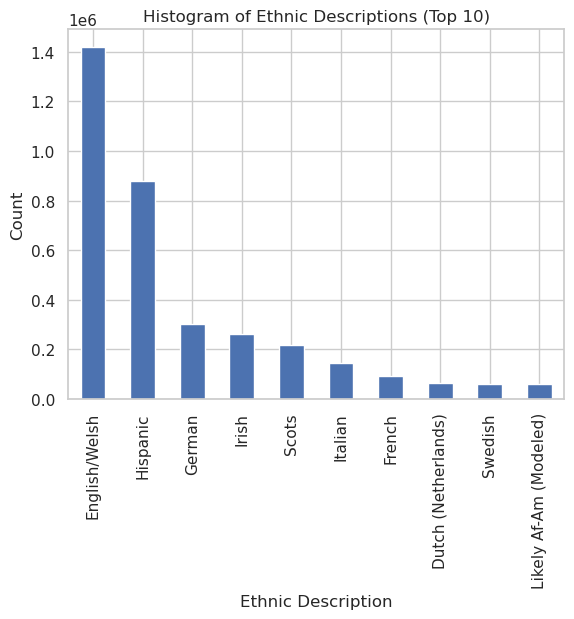

In [231]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = selected_df.select('Ethnic_Description').toPandas()

# Count occurrences of each category
ethnic_counts = pandas_df['Ethnic_Description'].value_counts()

# Select top 10 categories
top_10_ethnic = ethnic_counts.head(10)

# Plot histogram for top 10 categories
top_10_ethnic.plot(kind='bar', title='Histogram of Ethnic Descriptions (Top 10)')
plt.xlabel('Ethnic Description')
plt.ylabel('Count')
plt.show()

## A seperate Data Set for Analysis

This data set is for the next portion and only contains data that has missing observations. Although it can't be used machine leanring, there might be some cool insights within the missing data itself.

In [232]:
#filter_expr = F.exists(F.array(*df.columns), lambda x: x.isNull())
#only_missing_data = df_selected.filter(filter_expr)

# Modeling and Prediction For Which Party They Will Vote

We first check the amount of data and all predictors

In [237]:
from pyspark.sql import SparkSession

# Print the number of rows in the DataFrame
print(f"Number of rows: {cleaned_df.count()}")

# Print all the column names in the DataFrame
#print(f"Column names: {cleaned_df.columns}")

# Print the number of columns in the DataFrame
print(f"Number of columns: {len(cleaned_df.columns)}")


Number of rows: 4266400
Number of columns: 28


In [239]:
# cleaned_df = cleaned_df.select(
#     "LALVOTERID",
#     "Voters_Gender",
#     "Voters_Age",
#     "Ethnic_Description",
#     "Voters_PlaceOfBirth",
#     "Voters_FIPS",
#     "CountyEthnic_LALEthnicCode",
#     "CountyEthnic_Description",
#     "Parties_Description",
#     "Voters_VotingPerformanceEvenYearGeneral",
#     "Mailing_Families_HHCount",
#     "CommercialData_Education",
#     "CommercialData_EstimatedHHIncome",
#     "CommercialData_EstimatedAreaMedianHHIncome",
#     "CommercialData_AreaPcntHHMarriedCoupleWithChild",
#     "CommercialData_AreaPcntHHSpanishSpeaking",
#     "CommercialData_AreaMedianEducationYears",
#     "CommercialData_PoliticalContributerInHome",
#     "CommercialDataLL_Hispanic_Country_Origin",
#     "Vote_By_Mail_Area",
#     "ElectionReturns_G16_Cnty_Vote_Clinton_D",
#     "ElectionReturns_G16_Cnty_Vote_Trump_R",
#     "ElectionReturns_G12_Cnty_Vote_Obama_D",
#     "ElectionReturns_G12_Cnty_Vote_Romney_R",
#     "ElectionReturns_G08_Cnty_Vote_McCain_R",
#     "ElectionReturns_G08_Cnty_Vote_Obama_D",
#     "ElectionReturns_G08CountyTurnoutAllRegisteredVoters",
#     "ElectionReturns_G08CountyTurnoutDemocrats",
#     "ElectionReturns_G08CountyTurnoutIndependentsAllOthers",
#     "ElectionReturns_G08CountyTurnoutRepublicans",
#     "ElectionReturns_G12CountyTurnoutAllRegisteredVoters",
#     "ElectionReturns_G12CountyTurnoutDemocrats",
#     "ElectionReturns_G12CountyTurnoutIndependentsAllOthers",
#     "ElectionReturns_G12CountyTurnoutRepublicans",
#     "ElectionReturns_G16CountyTurnoutAllRegisteredVoters",
#     "ElectionReturns_G16CountyTurnoutDemocrats",
#     "ElectionReturns_G16CountyTurnoutIndependentsAllOthers",
#     "ElectionReturns_G16CountyTurnoutRepublicans"
# )

In [235]:
# Columns to drop
columns_to_drop = [
    "Voters_PlaceOfBirth",
    "CountyEthnic_LALEthnicCode",
    "CountyEthnic_Description",
    "CommercialDataLL_Hispanic_Country_Origin",
    "Vote_By_Mail_Area",
    "CommercialData_PoliticalContributerInHome",
    "CommercialData_Education",
    "CommercialData_EstimatedAreaMedianHHIncome",
    "CommercialData_AreaPcntHHMarriedCoupleWithChild",
    "CommercialData_AreaPcntHHSpanishSpeaking",
]

# Drop columns from the DataFrame
cleaned_df = cleaned_df.drop(*columns_to_drop)

In [240]:
print(f"Number of columns: {len(cleaned_df.columns)}")


Number of columns: 28


To accommodate computational resource limitations, we will strategically reduce our dataset for training the machine learning model. By randomly selecting approximately 1/100th of the data, we will work with a subset that includes 42,664 distinct individuals. This methodically reduced sample size is meticulously chosen to ensure that it still encapsulates a comprehensive overview, allowing us to discern meaningful trends in election results. 

In [241]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when

# Filter out rows with any missing data
cleaned_df_no_missing = cleaned_df.dropna()

# Select approximately 1/100th of rows randomly without any missing data
fraction_of_rows = 0.01
seed = 42
sampled_df_no_missing = cleaned_df_no_missing.sample(False, fraction_of_rows, seed)




In [242]:
# Print all the column names in the DataFrame
print(f"Column names: {sampled_df_no_missing.columns}")

Column names: ['LALVOTERID', 'Voters_Gender', 'Voters_Age', 'Ethnic_Description', 'Voters_FIPS', 'Parties_Description', 'Voters_VotingPerformanceEvenYearGeneral', 'Mailing_Families_HHCount', 'CommercialData_EstimatedHHIncome', 'CommercialData_AreaMedianEducationYears', 'ElectionReturns_G16_Cnty_Vote_Clinton_D', 'ElectionReturns_G16_Cnty_Vote_Trump_R', 'ElectionReturns_G12_Cnty_Vote_Obama_D', 'ElectionReturns_G12_Cnty_Vote_Romney_R', 'ElectionReturns_G08_Cnty_Vote_McCain_R', 'ElectionReturns_G08_Cnty_Vote_Obama_D', 'ElectionReturns_G08CountyTurnoutAllRegisteredVoters', 'ElectionReturns_G08CountyTurnoutDemocrats', 'ElectionReturns_G08CountyTurnoutIndependentsAllOthers', 'ElectionReturns_G08CountyTurnoutRepublicans', 'ElectionReturns_G12CountyTurnoutAllRegisteredVoters', 'ElectionReturns_G12CountyTurnoutDemocrats', 'ElectionReturns_G12CountyTurnoutIndependentsAllOthers', 'ElectionReturns_G12CountyTurnoutRepublicans', 'ElectionReturns_G16CountyTurnoutAllRegisteredVoters', 'ElectionReturns_

We then divide the dataframes into predictors and targets(all the ElectionReturns)

In [243]:
column_names = sampled_df_no_missing.columns

# Separate columns into predictors and targets based on column names
predictor_columns = [col for col in column_names if not col.startswith("ElectionReturns")]
target_columns = [col for col in column_names if col.startswith("ElectionReturns")]

# Select the predictors and targets from the DataFrame
predictors_df = sampled_df_no_missing.select(predictor_columns)
targets_df = sampled_df_no_missing.select(target_columns)


In [244]:

# Print the data types of all columns in predictors_df
for column, dtype in predictors_df.dtypes:
    print(f"Column: {column}, Type: {dtype}")


Column: LALVOTERID, Type: string
Column: Voters_Gender, Type: string
Column: Voters_Age, Type: string
Column: Ethnic_Description, Type: string
Column: Voters_FIPS, Type: string
Column: Parties_Description, Type: string
Column: Voters_VotingPerformanceEvenYearGeneral, Type: string
Column: Mailing_Families_HHCount, Type: string
Column: CommercialData_EstimatedHHIncome, Type: string
Column: CommercialData_AreaMedianEducationYears, Type: string


We print out the unique columns of each predictor to check if it should be a numerical variable or categorical varaible 

In [245]:
# from pyspark.sql.functions import countDistinct

# # Loop through each column and print the number of unique elements
# for column in predictors_df.columns:
#     unique_count = predictors_df.agg(countDistinct(col(column)).alias("unique_count"))
#     unique_count.show()


## Convert Numeric Variables to Float

In [246]:
from pyspark.sql.functions import col

# List of columns to be converted to float
float_columns = [
    'Voters_Age',
    'Voters_FIPS',
    'Mailing_Families_HHCount',
    'CommercialData_AreaMedianEducationYears'
]

# Convert columns to float
for column in float_columns:
    predictors_df = predictors_df.withColumn(column, col(column).cast('float'))


 ## Encode Categorical Variables

In [247]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# List of categorical columns (excluding 'LALVOTERID' if it's an identifier)
categorical_columns = [
    'Voters_Gender',  
    'Parties_Description',
    'Voters_VotingPerformanceEvenYearGeneral',
    'Ethnic_Description',
    'CommercialData_EstimatedHHIncome'
    
]


# Indexing categorical columns
indexers = [
    StringIndexer(inputCol=column, outputCol=column + "_index")
    for column in categorical_columns
]

# Encoding indexed columns
encoders = [
    OneHotEncoder(inputCols=[indexer.getOutputCol()], outputCols=[indexer.getOutputCol().replace("_index", "_vec")])
    for indexer in indexers
]

# Pipeline to apply indexing and encoding
pipeline = Pipeline(stages=indexers + encoders)

# Fit and transform the pipeline on the predictors dataframe
predictors_df_transformed = pipeline.fit(predictors_df).transform(predictors_df)

# Optionally, assemble all features into a single vector (useful for modeling)
assemblerInputs = [c + "_vec" for c in categorical_columns] + float_columns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
final_df = assembler.transform(predictors_df_transformed)



## Check Missing Data

In [251]:
from pyspark.sql.functions import col, count, isnan, when

# Check for missing data in each column
missing_data_check = predictors_df.select([
    count(when(isnan(c) | col(c).isNull(), c)).alias(c)
    for c in predictors_df.columns
])

missing_data_check.show()


+----------+-------------+----------+------------------+-----------+-------------------+---------------------------------------+------------------------+--------------------------------+---------------------------------------+
|LALVOTERID|Voters_Gender|Voters_Age|Ethnic_Description|Voters_FIPS|Parties_Description|Voters_VotingPerformanceEvenYearGeneral|Mailing_Families_HHCount|CommercialData_EstimatedHHIncome|CommercialData_AreaMedianEducationYears|
+----------+-------------+----------+------------------+-----------+-------------------+---------------------------------------+------------------------+--------------------------------+---------------------------------------+
|         0|            0|         0|                 0|          0|                  0|                                      0|                       0|                               0|                                      0|
+----------+-------------+----------+------------------+-----------+-------------------+----

In [252]:
from pyspark.sql.functions import col, count, isnan, when

# Check for missing data in each column
missing_data_check = targets_df.select([
    count(when(isnan(c) | col(c).isNull(), c)).alias(c)
    for c in targets_df.columns
])

missing_data_check.show()


+---------------------------------------+-------------------------------------+-------------------------------------+--------------------------------------+--------------------------------------+-------------------------------------+---------------------------------------------------+-----------------------------------------+-----------------------------------------------------+-------------------------------------------+---------------------------------------------------+-----------------------------------------+-----------------------------------------------------+-------------------------------------------+---------------------------------------------------+-----------------------------------------+-----------------------------------------------------+-------------------------------------------+
|ElectionReturns_G16_Cnty_Vote_Clinton_D|ElectionReturns_G16_Cnty_Vote_Trump_R|ElectionReturns_G12_Cnty_Vote_Obama_D|ElectionReturns_G12_Cnty_Vote_Romney_R|ElectionReturns_G08_Cnty_Vote_McCa

We then check the targets_df before implementing the machine learning model 

In [253]:
# from pyspark.sql.functions import countDistinct

# # Loop through each column in targets_df and print the count of unique elements
# for column in targets_df.columns:
#     unique_count = targets_df.agg(countDistinct(col(column)).alias("unique_count"))
#     unique_count.show()


## Change into Categorical Variable For Dependent Variables
We will use the most recent election (2016) Clinton results for this model.

In [254]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# List of target columns to be indexed
indexed_target_columns = ['ElectionReturns_G16_Cnty_Vote_Clinton_D']

# Create a StringIndexer for each column
indexers = [StringIndexer(inputCol=column, outputCol=f"{column}_index").fit(targets_df) for column in indexed_target_columns]

# Combine the indexers into a Pipeline
pipeline = Pipeline(stages=indexers)

# Fit and Transform the data
targets_df_transformed = pipeline.fit(targets_df).transform(targets_df)

# Show the transformed DataFrame with newly indexed columns
#targets_df_transformed.show()


## Random Forest

### Train Model and Evaluate on Test Data set

In [255]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import monotonically_increasing_id

# Add a unique ID to both final_df and targets_df_transformed to serve as a join key
final_df = final_df.withColumn("row_id", monotonically_increasing_id())
targets_df_transformed = targets_df_transformed.withColumn("row_id", monotonically_increasing_id())

# Select the first indexed target column in targets_df_transformed
target_col_index = indexed_target_columns_transformed[0]

# Join final_df with the current indexed target column from targets_df_transformed
data_with_labels = final_df.join(targets_df_transformed.select("row_id", target_col_index).withColumnRenamed(target_col_index, "label"), "row_id")

# Split the data into training and testing sets
(trainingData, testData) = data_with_labels.randomSplit([0.8, 0.2], seed=42)

# Define and train the Random Forest classifier
rfClassifier = RandomForestClassifier(featuresCol="features", labelCol="label")
model = rfClassifier.fit(trainingData)

# Make predictions and evaluate the model
predictions = model.transform(testData)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the model's performance for the first target
print(f"Random Forest Model for {target_col_index.replace('_index', '')}: Accuracy = {accuracy}")


Random Forest Model for ElectionReturns_G16_Cnty_Vote_Clinton_D: Accuracy = 0.6917113053284466


### Grid Search Parameter tunning

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import monotonically_increasing_id

# Add a unique ID to both final_df and targets_df_transformed to serve as a join key
final_df = final_df.withColumn("row_id", monotonically_increasing_id())
targets_df_transformed = targets_df_transformed.withColumn("row_id", monotonically_increasing_id())

# Select the first indexed target column in targets_df_transformed
target_col_index = indexed_target_columns_transformed[0]

# Join final_df with the current indexed target column from targets_df_transformed
data_with_labels = final_df.join(targets_df_transformed.select("row_id", target_col_index).withColumnRenamed(target_col_index, "label"), "row_id")

# Split the data into training and testing sets
(trainingData, testData) = data_with_labels.randomSplit([0.8, 0.2], seed=42)

# Define the Random Forest classifier
rfClassifier = RandomForestClassifier(featuresCol="features", labelCol="label")

# Create the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(rfClassifier.numTrees, [10, 20, 50])
             .addGrid(rfClassifier.maxDepth, [5, 10, 20])
             .addGrid(rfClassifier.impurity, ["gini", "entropy"])
             .build())

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Set up the CrossValidator
crossval = CrossValidator(estimator=rfClassifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Use 3+ folds in practice

# Fit the model using CrossValidator
cvModel = crossval.fit(trainingData)

# Fetch best model
bestModel = cvModel.bestModel

# Make predictions on the test data with the best model
predictions = bestModel.transform(testData)

# Evaluate the best model's performance on the test data
accuracy = evaluator.evaluate(predictions)

# Print out the performance of the best random forest model for the first target
print(f"Best Random Forest Model for {target_col_index.replace('_index', '')}: Accuracy = {accuracy}")

# Print best model's parameters
print(f"Best NumTrees: {bestModel.getNumTrees}")
print(f"Best MaxDepth: {bestModel.getMaxDepth()}")
print(f"Best Impurity: {bestModel.getImpurity()}")


24/03/19 00:14:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1186.8 KiB
24/03/19 00:15:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1067.8 KiB
24/03/19 00:15:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1441.7 KiB
24/03/19 00:15:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1001.6 KiB
24/03/19 00:15:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1186.8 KiB
24/03/19 00:15:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1536.1 KiB
24/03/19 00:15:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1953.6 KiB
24/03/19 00:15:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/03/19 00:15:07 WARN org.apache.spark.scheduler.DAGScheduler: Broadcastin

Best Random Forest Model for ElectionReturns_G16_Cnty_Vote_Clinton_D: Accuracy = 0.9403721454750493
Best NumTrees: 50
Best MaxDepth: 20
Best Impurity: gini


### Variable Importance Plot

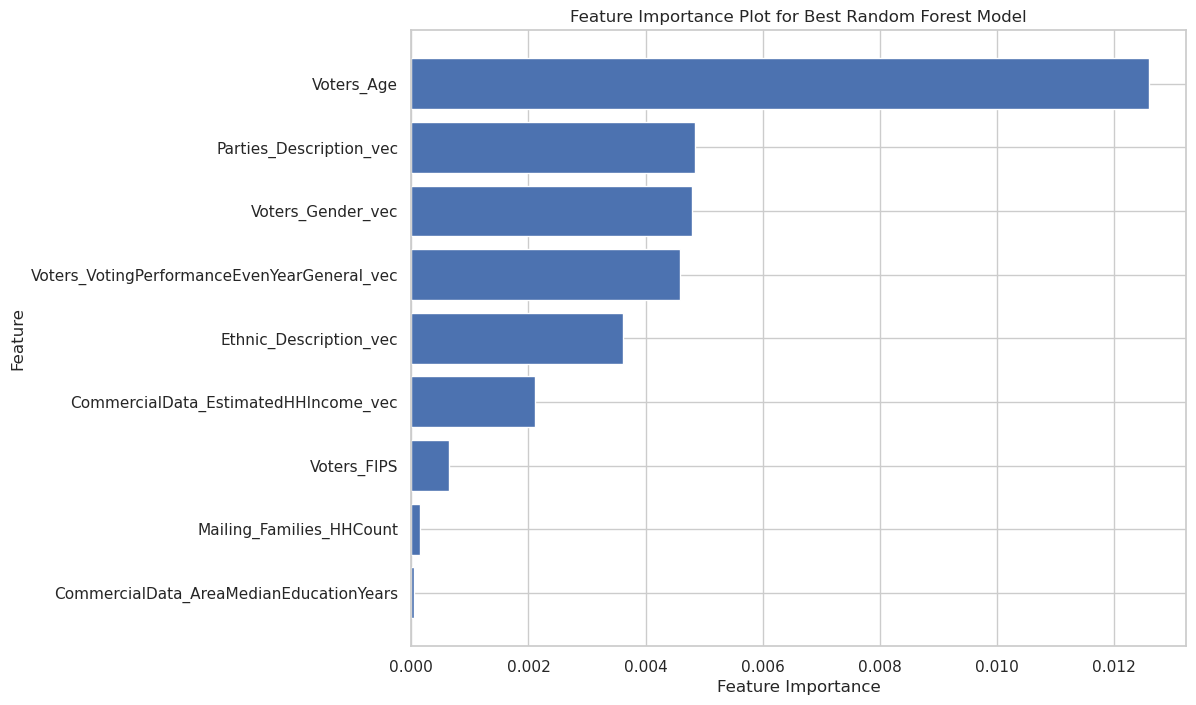

In [ ]:
# Fetch the best model
bestModel = cvModel.bestModel

# Extract feature importances from the best model
feature_importances = bestModel.featureImportances.toArray()

# Assuming you have the feature names stored in assemblerInputs
feature_names = assemblerInputs

# Zip together feature names and their importances
feature_importance_zip = zip(feature_names, feature_importances)

# Sort the features by importance
sorted_feature_importances = sorted(feature_importance_zip, key=lambda x: x[1], reverse=True)

# Unzip the features and their importances for plotting
features, importances = zip(*sorted_feature_importances)

# Create the plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot for Best Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

`Voters_Age`  emerged as the most significant feature. This indicates that the age of the voters is a strong predictor of party preference, which could be reflective of different political priorities and values across various age demographics.

The next notable features include `Parties_Description_vec` and `Voters_Gender_vec`, suggesting that a voter's registered party affiliation and gender are influential in their voting behavior. This aligns with common understanding that individuals often vote in alignment with their registered party, and certain issues may be more salient to voters based on gender, affecting their party choice.

`Voters_VotingPerformanceEvenYearGeneral_vec` and `Ethnic_Description_vec` also play a role, albeit to a lesser extent. These variables imply that voting patterns in previous general elections and ethnic background contribute to the prediction of voting behavior, potentially due to historical loyalty to a party or the resonance of ethnic identity with party policies.

Interestingly, the previously dominant feature `Mailing_Families_HHCount` has decreased in relative importance, although still a factor, indicating that while the structure of households matters, it may not be as decisive when considering additional variables like age and ethnicity.

The inclusion of `CommercialData_EstimatedHHIncome_vec` suggests that estimated household income is a factor in the electoral decision-making process, with voters' economic status potentially influencing their party choice.

Lastly, `Voters_FIPS`, which indicates a geographical component, and `CommercialData_AreaMedianEducationYears` show the least importance in this model iteration but still contribute to the predictive power, hinting that regional aspects and educational context bear some weight on how individuals vote.


## Logsitic Regression

### Train Model and Evaluate on Test Data set

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import monotonically_increasing_id

# Add a unique ID to both final_df and targets_df_transformed to serve as a join key
final_df = final_df.withColumn("row_id", monotonically_increasing_id())
targets_df_transformed = targets_df_transformed.withColumn("row_id", monotonically_increasing_id())

# Select the first indexed target column in targets_df_transformed
target_col_index = indexed_target_columns_transformed[0]

# Join final_df with the current indexed target column from targets_df_transformed
data_with_labels = final_df.join(targets_df_transformed.select("row_id", target_col_index).withColumnRenamed(target_col_index, "label"), "row_id")

# Split the data into training and testing sets
(trainingData, testData) = data_with_labels.randomSplit([0.8, 0.2], seed=42)

# Define and train the Logistic Regression classifier
lrClassifier = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model on the training data
lrModel = lrClassifier.fit(trainingData)

# Make predictions on the test data
predictions = lrModel.transform(testData)

# Evaluate the model using the evaluator with accuracy metric
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print out the performance of the logistic regression model for the first target
print(f"Logistic Regression Model for {target_col_index.replace('_index', '')}: Accuracy = {accuracy}")


Logistic Regression Model for ElectionReturns_G16_Cnty_Vote_Clinton_D: Accuracy = 0.6281364533408514


### Grid Search Parameter tunning

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import monotonically_increasing_id

# Add a unique ID to both final_df and targets_df_transformed to serve as a join key
final_df = final_df.withColumn("row_id", monotonically_increasing_id())
targets_df_transformed = targets_df_transformed.withColumn("row_id", monotonically_increasing_id())

# Select the first indexed target column in targets_df_transformed
target_col_index = indexed_target_columns_transformed[0]

# Join final_df with the current indexed target column from targets_df_transformed
data_with_labels = final_df.join(targets_df_transformed.select("row_id", target_col_index).withColumnRenamed(target_col_index, "label"), "row_id")

# Split the data into training and testing sets
(trainingData, testData) = data_with_labels.randomSplit([0.8, 0.2], seed=42)

# Define the Logistic Regression classifier
lrClassifier = LogisticRegression(featuresCol="features", labelCol="label")

# Create the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(lrClassifier.maxIter, [10, 50, 100])
             .addGrid(lrClassifier.regParam, [0.1, 0.01, 0.001])
             .addGrid(lrClassifier.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Set up the CrossValidator
crossval = CrossValidator(estimator=lrClassifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Use 3+ folds in practice

# Fit the model using CrossValidator
cvModel = crossval.fit(trainingData)

# Fetch best model
bestModel = cvModel.bestModel

# Make predictions on the test data with the best model
predictions = bestModel.transform(testData)

# Evaluate the best model's performance on the test data
accuracy = evaluator.evaluate(predictions)

# Print out the performance of the best logistic regression model for the first target
print(f"Best Logistic Regression Model for {target_col_index.replace('_index', '')}: Accuracy = {accuracy}")

# Print best model's hyperparameters
print(f"Best maxIter: {bestModel._java_obj.getMaxIter()}")
print(f"Best regParam: {bestModel._java_obj.getRegParam()}")
print(f"Best elasticNetParam: {bestModel._java_obj.getElasticNetParam()}")


Best Logistic Regression Model for ElectionReturns_G16_Cnty_Vote_Clinton_D: Accuracy = 0.891598533972371
Best maxIter: 100
Best regParam: 0.001
Best elasticNetParam: 1.0


### Variable Importance Plot (F-score)

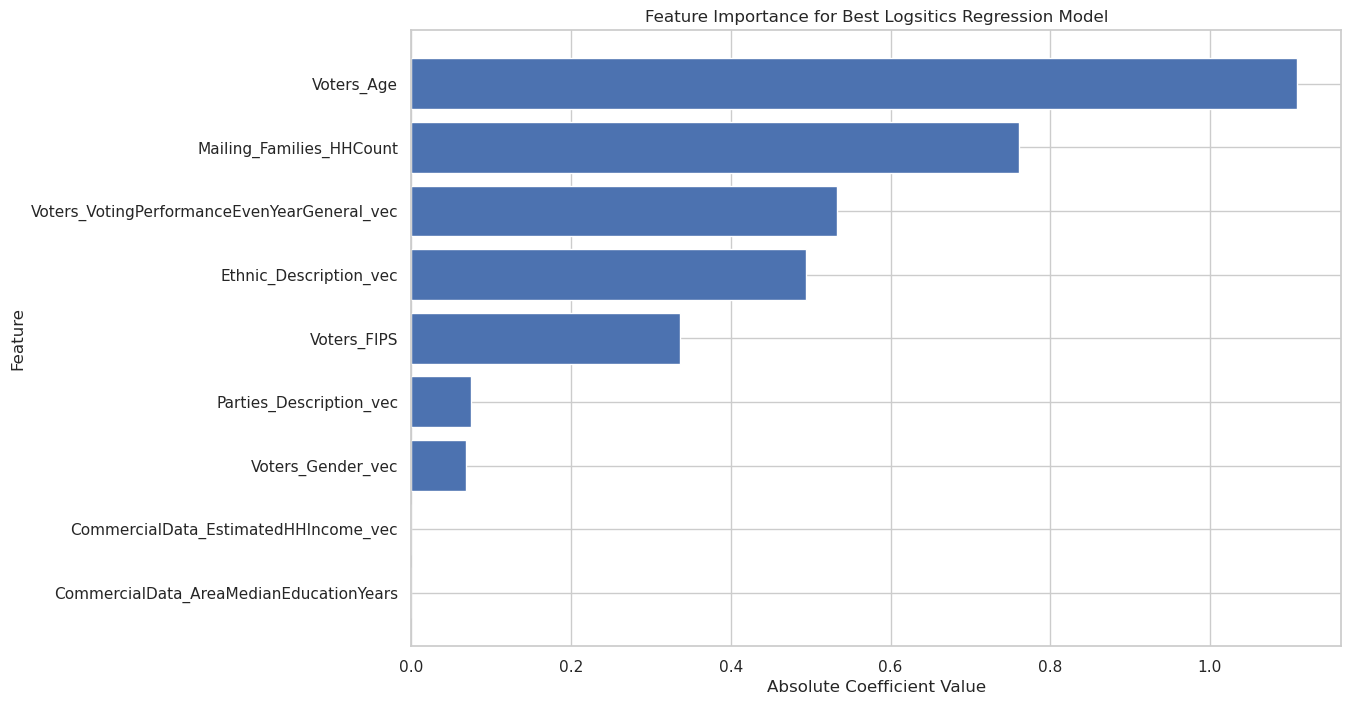

In [ ]:
from pyspark.ml.classification import LogisticRegressionModel
import matplotlib.pyplot as plt
import numpy as np

# We're using the best model from the cross-validation process
bestModel = cvModel.bestModel

# Check if the best model is indeed a LogisticRegressionModel and if it's a binary classification problem
if isinstance(bestModel, LogisticRegressionModel):
    if bestModel.numClasses == 2:  # Binary classification
        # Extract coefficients for the binary classification case
        coefficients = bestModel.coefficients.toArray()
    else:  # Multiclass classification
        # Extract coefficients for the multiclass classification case, taking the first class for example
        coefficients = bestModel.coefficientMatrix.toArray()[0]
else:
    raise ValueError("The best model obtained from cross-validation is not a LogisticRegressionModel.")

# Take the absolute value of the coefficients for importance
coefficients = np.abs(coefficients)

# Assuming feature_names are stored in assemblerInputs
feature_names = assemblerInputs

# Zip feature names with their coefficients
feature_coefficients_zip = zip(feature_names, coefficients)

# Sort features by their coefficient value
sorted_feature_coefficients = sorted(feature_coefficients_zip, key=lambda x: x[1], reverse=True)

# Unzip into two lists for plotting
features, importances = zip(*sorted_feature_coefficients)

# Create the plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(features)), importances, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title(f'Feature Importance for Best Logsitics Regression Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


In the logistic regression model's feature importance plot, `Voters_Age` stands out as the most significant predictor, indicating that the age of voters is crucial in determining their party preference. This could be due to generational differences in priorities and values or varying impacts of political issues on different age groups.

Following `Voters_Age`, the `Mailing_Families_HHCount` and `Voters_VotingPerformanceEvenYearGeneral_vec` features are also influential, which highlights the importance of household composition and consistent voting behavior in elections, suggesting that these factors are indicative of certain voting patterns or party loyalties.

Other features such as `Ethnic_Description_vec`, `Voters_FIPS`, and `Parties_Description_vec` suggest that ethnic background, geographic location, and party affiliation are also relevant, albeit to a lesser degree. These reflect the nuanced interplay between ethnicity, local political trends, and identified party alignment in shaping voter preferences.

The smaller coefficients for features like `Voters_Gender_vec`, `CommercialData_EstimatedHHIncome_vec`, and `CommercialData_AreaMedianEducationYears` indicate that while they do contribute to the model, their impact on predicting party preference is relatively modest compared to the stronger predictors such as age and household count.

## Final Analysis

### Model Perfomance Comparsion

The Logistic Regression model achieved a commendable accuracy of approximately 89.15% in predicting the 2016 U.S. election voting behavior for Hillary Clinton, signifying a strong predictive capability. However, the Random Forest model outperformed it, reaching an accuracy of roughly 94.03%, indicating an even more robust model in terms of prediction for this particular election result. The higher accuracy of the Random Forest model suggests that its approach to handling the complexity and interactions between features is more effective for this dataset.

### Variable Selection Comparsion

Analyzing the feature importance from both the Random Forest and Logistic Regression models offers a comprehensive view of the variables that most significantly impact voter preferences in the 2016 U.S. election.

From both models, `Voters_Age` is highlighted as a primary predictor, indicating age-related factors such as generational values or issue sensitivity play a pivotal role in political leanings. `Mailing_Families_HHCount` emerges as another key variable, especially in the Random Forest model, pointing to the influence of household composition on voting decisions. This could suggest that factors like family size or structure have a pronounced effect on political preferences.

Consistent voting behavior, captured by `Voters_VotingPerformanceEvenYearGeneral_vec`, is also established as important across both models, suggesting a strong link between regular voting patterns and party loyalty.

The importance of `Ethnic_Description_vec` and `Voters_FIPS` in the Random Forest model underscores the role of ethnic identity and regional characteristics, indicating that cultural background and local issues are influential in shaping voter behavior.

`Parties_Description_vec` stands out in the Logistic Regression model, reflecting the anticipated impact of party affiliation on voter choice, although it is less pronounced in the Random Forest analysis.


# Modeling and Prediction For If They Will Vote

We treat ElectionReturns_G16CountyTurnoutAllRegisteredVoters as a categorical variable. 

In [269]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# List of target columns to be indexed
indexed_target_columns = ['ElectionReturns_G16CountyTurnoutAllRegisteredVoters']

# Create a StringIndexer for each column
indexers = [StringIndexer(inputCol=column, outputCol=f"{column}_index").fit(targets_df) for column in indexed_target_columns]

# Combine the indexers into a Pipeline
pipeline = Pipeline(stages=indexers)

# Fit and Transform the data
targets_df_transformed = pipeline.fit(targets_df).transform(targets_df)

# Show the transformed DataFrame with newly indexed columns
#targets_df_transformed.show()


In [268]:
from pyspark.sql.functions import col

# Assuming 'targets_df' is the DataFrame containing the 'ElectionReturns_G16CountyTurnoutAllRegisteredVoters' column

# Group by the unique values in the 'ElectionReturns_G16CountyTurnoutAllRegisteredVoters' column
# and count the number of occurrences of each unique value
value_counts = targets_df.groupBy('ElectionReturns_G16CountyTurnoutAllRegisteredVoters').count()

# Calculate the total count
total_count = targets_df.count()

# Add a new column with the relative portion of each unique value
value_counts_with_portion = value_counts.withColumn('portion', col('count') / total_count)

# Show the result
value_counts_with_portion.show()


+---------------------------------------------------+-----+--------------------+
|ElectionReturns_G16CountyTurnoutAllRegisteredVoters|count|             portion|
+---------------------------------------------------+-----+--------------------+
|                                                66%|22840|  0.6278692580476675|
|                                                54%|   21|5.772878467163317E-4|
|                                                57%| 1152|  0.0316683618770102|
|                                                69%| 5783|  0.1589740770266927|
|                                                58%| 2361| 0.06490364790939329|
|                                                60%|  780| 0.02144212002089232|
|                                                51%|  895|0.024603458229100806|
|                                                59%|  290|0.007972070264177915|
|                                                64%|  842|0.023146493663578634|
|                           

In [272]:
# Assuming 'ElectionReturns_G16CountyTurnoutAllRegisteredVoters' is the correct column to predict
indexed_target_columns = ['ElectionReturns_G16CountyTurnoutAllRegisteredVoters']

# Now create the StringIndexers
indexers = [StringIndexer(inputCol=column, outputCol=f"{column}_index") for column in indexed_target_columns]

# Combine the indexers into a Pipeline
pipeline = Pipeline(stages=indexers)

# Fit and Transform the data
targets_df_transformed = pipeline.fit(targets_df).transform(targets_df)

# The column with "_index" should be the column created by StringIndexer
target_col_index = indexed_target_columns[0] + "_index"

# Add a unique ID to the final_df DataFrame
if "row_id" not in final_df.columns:
    final_df = final_df.withColumn("row_id", monotonically_increasing_id())

# Add a unique ID to the targets_df_transformed DataFrame
if "row_id" not in targets_df_transformed.columns:
    targets_df_transformed = targets_df_transformed.withColumn("row_id", monotonically_increasing_id())

# Now proceed with your join
data_with_labels = final_df.join(targets_df_transformed.select("row_id", target_col_index).withColumnRenamed(target_col_index, "label"), "row_id")


## Random Forest

In [274]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import monotonically_increasing_id

# Ensure 'row_id' is added to final_df only once
if "row_id" not in final_df.columns:
    final_df = final_df.withColumn("row_id", monotonically_increasing_id())

# Ensure 'row_id' is added to targets_df_transformed only once
if "row_id" not in targets_df_transformed.columns:
    targets_df_transformed = targets_df_transformed.withColumn("row_id", monotonically_increasing_id())

# The target column we want to predict now is 'ElectionReturns_G16CountyTurnoutAllRegisteredVoters'
# Update the target_col_index accordingly
target_col_index = 'ElectionReturns_G16CountyTurnoutAllRegisteredVoters_index'

# Join final_df with the newly indexed target column from targets_df_transformed
data_with_labels = final_df.join(targets_df_transformed.select("row_id", target_col_index).withColumnRenamed(target_col_index, "label"), "row_id")

# Split the data into training and testing sets
(trainingData, testData) = data_with_labels.randomSplit([0.8, 0.2], seed=42)

# Define the Random Forest classifier
rfClassifier = RandomForestClassifier(featuresCol="features", labelCol="label")

# Fit the Random Forest model on the training data
model = rfClassifier.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Define the evaluator for accuracy metric
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Evaluate the accuracy of the model on the test data
accuracy = evaluator.evaluate(predictions)

# Print the model's performance for the target column
print(f"Random Forest Model for {target_col_index.replace('_index', '')}: Accuracy = {accuracy}")


Random Forest Model for ElectionReturns_G16CountyTurnoutAllRegisteredVoters: Accuracy = 0.6629546095291796


In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import monotonically_increasing_id

# Ensure 'row_id' is added to final_df only once
if "row_id" not in final_df.columns:
    final_df = final_df.withColumn("row_id", monotonically_increasing_id())

# Ensure 'row_id' is added to targets_df_transformed only once
if "row_id" not in targets_df_transformed.columns:
    targets_df_transformed = targets_df_transformed.withColumn("row_id", monotonically_increasing_id())

# The target column we want to predict now is 'ElectionReturns_G16CountyTurnoutAllRegisteredVoters'
# Update the target_col_index accordingly
target_col_index = 'ElectionReturns_G16CountyTurnoutAllRegisteredVoters_index'

# Join final_df with the newly indexed target column from targets_df_transformed
data_with_labels = final_df.join(targets_df_transformed.select("row_id", target_col_index).withColumnRenamed(target_col_index, "label"), "row_id")

# Split the data into training and testing sets
(trainingData, testData) = data_with_labels.randomSplit([0.8, 0.2], seed=42)

# Define the Random Forest classifier
rfClassifier = RandomForestClassifier(featuresCol="features", labelCol="label")

# Create the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(rfClassifier.numTrees, [10, 20, 50])
             .addGrid(rfClassifier.maxDepth, [5, 10, 20])
             .addGrid(rfClassifier.impurity, ["gini", "entropy"])
             .build())

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Set up the CrossValidator
crossval = CrossValidator(estimator=rfClassifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Use 3+ folds in practice

# Fit the model using CrossValidator to find the best model
cvModel = crossval.fit(trainingData)

# Fetch the best model
bestModel = cvModel.bestModel

# Make predictions on the test data with the best model
predictions = bestModel.transform(testData)

# Evaluate the best model's performance on the test data
accuracy = evaluator.evaluate(predictions)

# Print out the performance of the best random forest model for the first target
print(f"Best Random Forest Model for {target_col_index.replace('_index', '')}: Accuracy = {accuracy}")

# Print best model's parameters
print(f"Best NumTrees: {bestModel.getNumTrees}")
print(f"Best MaxDepth: {bestModel.getMaxDepth()}")
print(f"Best Impurity: {bestModel.getImpurity()}")


24/03/19 01:55:24 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1036.3 KiB
24/03/19 01:55:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1192.7 KiB
24/03/19 01:55:33 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1036.3 KiB
24/03/19 01:55:33 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1308.0 KiB
24/03/19 01:55:33 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1639.5 KiB
24/03/19 01:55:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2031.3 KiB
24/03/19 01:55:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/03/19 01:55:35 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/03/19 01:55:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting l

Best Random Forest Model for ElectionReturns_G16CountyTurnoutAllRegisteredVoters: Accuracy = 0.962080631519594
Best NumTrees: 50
Best MaxDepth: 20
Best Impurity: gini


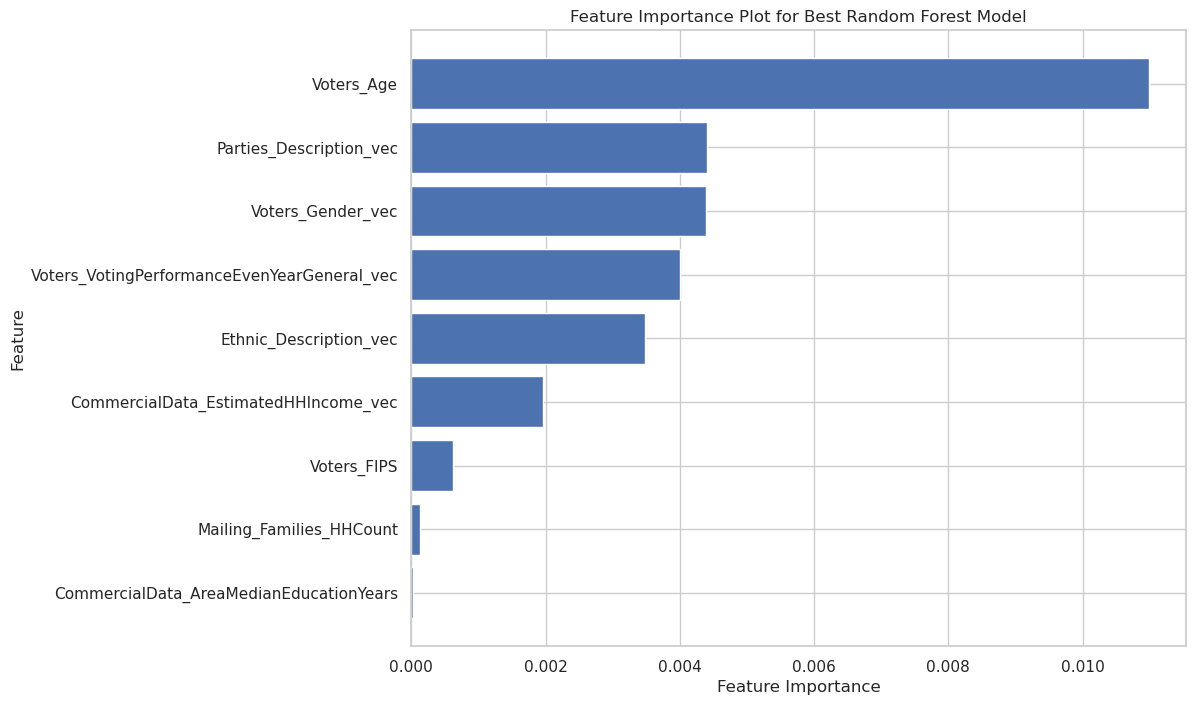

In [ ]:
# Fetch the best model
bestModel = cvModel.bestModel

# Extract feature importances from the best model
feature_importances = bestModel.featureImportances.toArray()

# Assuming you have the feature names stored in assemblerInputs
feature_names = assemblerInputs

# Zip together feature names and their importances
feature_importance_zip = zip(feature_names, feature_importances)

# Sort the features by importance
sorted_feature_importances = sorted(feature_importance_zip, key=lambda x: x[1], reverse=True)

# Unzip the features and their importances for plotting
features, importances = zip(*sorted_feature_importances)

# Create the plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot for Best Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

In the variable importance plot for the best Random Forest model predicting the turnout (`ElectionReturns_G16CountyTurnoutAllRegisteredVoters`), `Voters_Age` appears as the most significant predictor. This prominence suggests that voter turnout is strongly associated with age, possibly reflecting different levels of political engagement or motivation among various age groups.

The `Parties_Description_vec` and `Voters_Gender_vec` are also influential, indicating that a voter’s registered party and gender are meaningful predictors of whether they will vote. These factors might be capturing the impact of party loyalty and gender-specific political mobilization or issues that can motivate individuals to participate in an election.

Other notable features include `Voters_VotingPerformanceEvenYearGeneral_vec` and `Ethnic_Description_vec`. The former suggests that past voting behavior is indicative of future turnout, while the latter implies that ethnic identity can have a bearing on electoral participation, potentially due to community-level mobilization efforts or shared concerns that drive voter turnout within certain ethnic groups.

`CommercialData_EstimatedHHIncome_vec` is another feature with some importance, implying that household income levels may influence the decision to vote, possibly through the lens of economic wellbeing or policy impact perceptions.

The plot indicates that both individual characteristics (like age and gender) and broader socio-economic factors (such as estimated household income) play a role in predicting voter turnout, providing insights into the various influences that drive electoral participation.

## Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import monotonically_increasing_id

# Ensure 'row_id' is added to final_df only once
if "row_id" not in final_df.columns:
    final_df = final_df.withColumn("row_id", monotonically_increasing_id())

# Ensure 'row_id' is added to targets_df_transformed only once
if "row_id" not in targets_df_transformed.columns:
    targets_df_transformed = targets_df_transformed.withColumn("row_id", monotonically_increasing_id())

# Update the target_col_index to the indexed column for voter turnout
target_col_index = 'ElectionReturns_G16CountyTurnoutAllRegisteredVoters_index'

# Join final_df with the current indexed target column from targets_df_transformed
data_with_labels = final_df.join(targets_df_transformed.select("row_id", target_col_index).withColumnRenamed(target_col_index, "label"), "row_id")

# Split the data into training and testing sets
(trainingData, testData) = data_with_labels.randomSplit([0.8, 0.2], seed=42)

# Define the Logistic Regression classifier with initial parameters
lrClassifier = LogisticRegression(featuresCol="features", labelCol="label")

# Fit the model on the training data
lrModel = lrClassifier.fit(trainingData)

# Make predictions on the test data
predictions = lrModel.transform(testData)

# Evaluate the model using the evaluator with accuracy metric
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print out the performance of the logistic regression model for the turnout target
print(f"Logistic Regression Model for {target_col_index.replace('_index', '')}: Accuracy = {accuracy}")


Logistic Regression Model for ElectionReturns_G16CountyTurnoutAllRegisteredVoters: Accuracy = 0.9471384268395827


As the Accuracy is already 95%, we will skip the parameter tuning with cross-validation for this one.

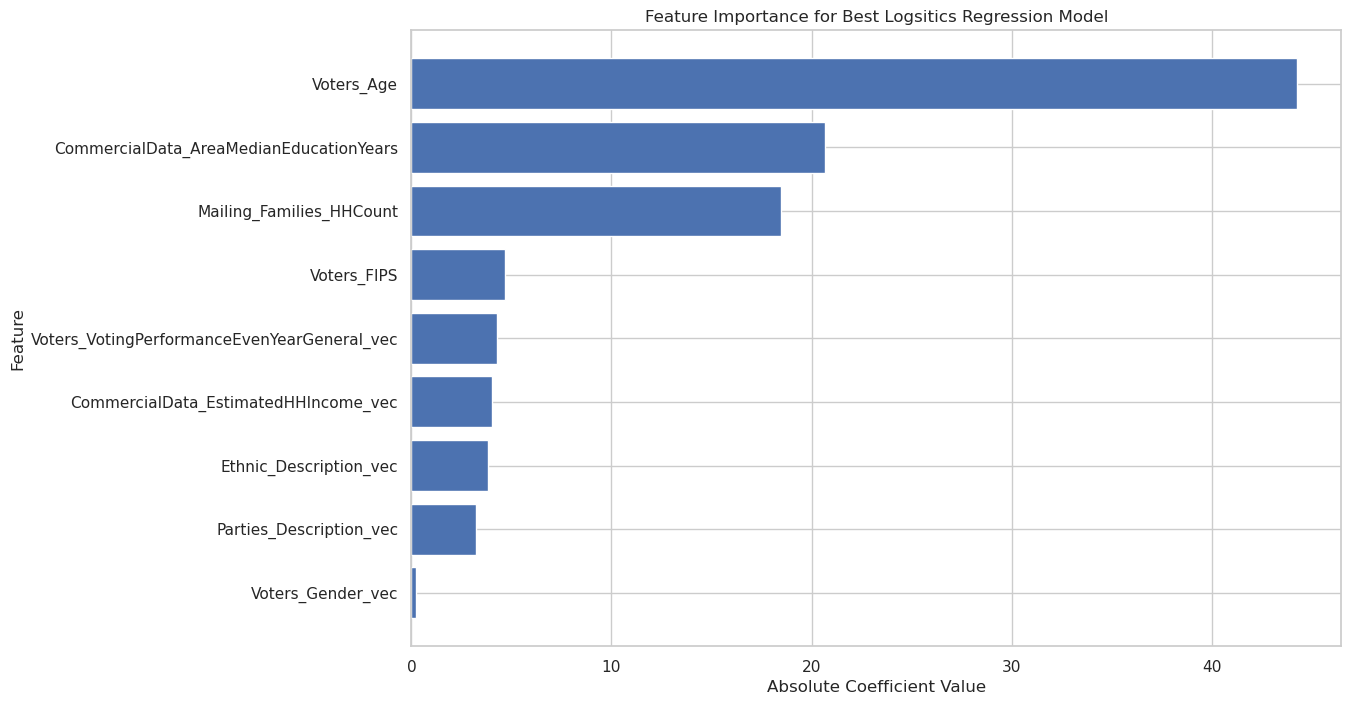

In [285]:
from pyspark.ml.classification import LogisticRegressionModel
import matplotlib.pyplot as plt
import numpy as np

# We're using the best model from the cross-validation process
bestModel = lrModel

# Check if the best model is indeed a LogisticRegressionModel and if it's a binary classification problem
if isinstance(bestModel, LogisticRegressionModel):
    if bestModel.numClasses == 2:  # Binary classification
        # Extract coefficients for the binary classification case
        coefficients = bestModel.coefficients.toArray()
    else:  # Multiclass classification
        # Extract coefficients for the multiclass classification case, taking the first class for example
        coefficients = bestModel.coefficientMatrix.toArray()[0]
else:
    raise ValueError("The best model obtained from cross-validation is not a LogisticRegressionModel.")

# Take the absolute value of the coefficients for importance
coefficients = np.abs(coefficients)

# Assuming feature_names are stored in assemblerInputs
feature_names = assemblerInputs

# Zip feature names with their coefficients
feature_coefficients_zip = zip(feature_names, coefficients)

# Sort features by their coefficient value
sorted_feature_coefficients = sorted(feature_coefficients_zip, key=lambda x: x[1], reverse=True)

# Unzip into two lists for plotting
features, importances = zip(*sorted_feature_coefficients)

# Create the plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(features)), importances, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title(f'Feature Importance for Best Logsitics Regression Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


Notably, age stands out as the variable with the greatest impact. This prominence is not surprising; traditionally, older voters have shown higher turnout rates, reflecting higher political engagement or a sense of civic duty developed over time.

On the other hand, the importance of the median years of education within an area is also highlighted. This variable's significance could be attributed to the correlation between education and political awareness. Educated individuals are generally more informed about political issues and more likely to participate in the electoral process.

However, certain variables, such as the number of households in a mailing list for families (Mailing_Families_HHCount) and the FIPS code (Voters_FIPS), seem less intuitively relevant. The FIPS code, being a geographic identifier, could be a proxy for region-specific political tendencies, but on its own, without additional contextual data, its usefulness might be limited. Similarly, while the number of family households might reflect the community size or type, its direct relationship to voter turnout is less clear. It raises questions about the nature of this data and how it's being applied within the model.

Variables encoding historical voting performance and estimated household income are expected to be relevant because they encapsulate behavioral trends and the means to facilitate voting, respectively. Nonetheless, these encoded variables (indicated by the suffix '_vec') should be used cautiously, as they may be overly fitted to historical data, which does not always predict future outcomes, especially in fluctuating political climates.

Furthermore, the significance assigned to ethnicity and party description seems rational, considering the cultural and political factors influencing voter turnout. However, their encoded forms suggest they've been transformed into a format the model can use, which could obscure their real-world interpretability.

Lastly, gender's influence, while important, raises questions about its practicality. Modern voter turnout trends show that the gap in voter turnout between genders is narrowing, suggesting that gender may not be as predictive as other more dynamic social factors.


## Final Analysis

When evaluating the importance of variables across both logistic regression and random forest models in predicting voter turnout, several key variables emerge as significant in both, affirming their influence. The consistency across models in highlighting these variables bolsters the confidence in their relevance.

**Voters_Age** consistently appears as a top predictor in both models. This underscores the idea that age is a crucial determinant of voter turnout, which aligns well with the observation that older populations tend to have higher rates of electoral participation. Age reflects not just the propensity to vote but also generational differences in political socialization and engagement.

The **Parties_Description_vec** and **Voters_Gender_vec** also rank as important in the random forest model. If these variables are similarly significant in the logistic regression model, it would further emphasize the role of party affiliation and gender in influencing voter behavior. Party identification is a strong motivator for turnout, as it often correlates with political interest and engagement, while gender might indicate differences in policy preferences or mobilization patterns.

Variables such as **Voters_VotingPerformanceEvenYearGeneral_vec** and **Ethnic_Description_vec** suggest that both historical voting patterns and ethnic identity are predictive of voter turnout. The importance of these variables across different models points to the persistence of past behavior as an indicator of future actions and the potential impact of ethnic group dynamics on voting.

**CommercialData_EstimatedHHIncome_vec**’s importance in the random forest model suggests economic factors are also at play. If household income also emerges as significant in the logistic regression analysis, it would confirm the theory that socioeconomic status can affect an individual’s likelihood to vote, possibly due to differences in policy impact or accessibility to voting resources.

When combining insights from both models, the important variables reflect a mix of individual demographic factors and broader socio-economic conditions. The overlapping importance of these variables reinforces their relevance. However, some variables may not exhibit the same level of importance across models, indicating potential model-specific biases or interactions within the data.



# Visualization

## Voting Trends

To begin, we will first present voter turnout percentage by county for Arizona from the main presedential election years 2008-2016.

In [24]:
from pyspark.sql.types import (StructType, 
                               StructField, 
                               DateType, 
                               BooleanType,
                               DoubleType,
                               IntegerType,
                               StringType)

cleaned_df2 = cleaned_df

def percToProp(mystr):
    return int(mystr.strip("%"))


udfpercToProp = F.udf(percToProp, IntegerType())
new_lst = []


cleaned_df2 = cleaned_df2.withColumn('ElectionReturns_G08CountyTurnoutAllRegisteredVoters',
                                    udfpercToProp(cleaned_df2.ElectionReturns_G08CountyTurnoutAllRegisteredVoters))

cleaned_df2 = cleaned_df2.withColumn('ElectionReturns_G12CountyTurnoutAllRegisteredVoters',
                                    udfpercToProp(cleaned_df2.ElectionReturns_G12CountyTurnoutAllRegisteredVoters))

cleaned_df2 = cleaned_df2.withColumn('ElectionReturns_G16CountyTurnoutAllRegisteredVoters',
                                    udfpercToProp(cleaned_df2.ElectionReturns_G16CountyTurnoutAllRegisteredVoters))



cleaned_main_election_returns = cleaned_df2.select( ['County','ElectionReturns_G08CountyTurnoutAllRegisteredVoters', 
        'ElectionReturns_G12CountyTurnoutAllRegisteredVoters','ElectionReturns_G16CountyTurnoutAllRegisteredVoters'])


([<matplotlib.axis.XTick at 0x7fe1b28a9070>,
 [Text(0, 0, '2008'), Text(1, 0, '2012'), Text(2, 0, '2016')])

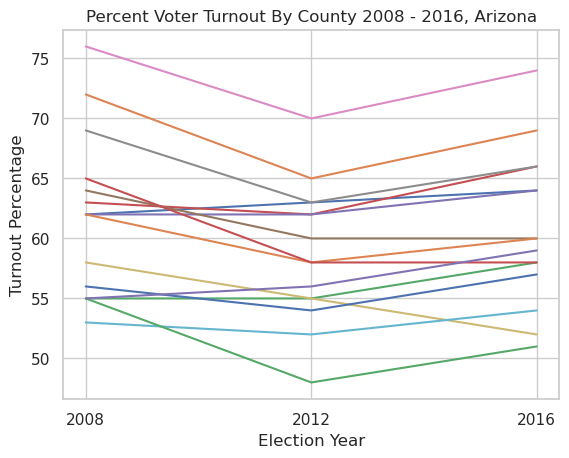

In [25]:
county_returns_az = cleaned_main_election_returns.select("*").distinct().toPandas()



i = 0
names_az = county_returns_az.iloc[:,0]

for i in range(len(county_returns_az)):
    plt.plot(county_returns_az.iloc[:,[1,2,3]].loc[i])
    i += 1

    

plt.title("Percent Voter Turnout By County 2008 - 2016, Arizona")
plt.xlabel("Election Year")
plt.ylabel("Turnout Percentage")
plt.xticks([0,1,2], labels = ['2008','2012','2016'])

Above, we observe a consistent pattern in voting trends for each county from 2008 to 2016. There is a noticeable dip in voter turnout in 2012, whereas in the other election years (2008 and 2016), voter turnout percentages tend to be higher.

## Gender Distribution

In [26]:
import matplotlib.pyplot as plt
grouped = cleaned_df2.select('Voters_Gender').groupby('Voters_Gender').count()
gender = [row[0] for row in grouped.select('Voters_Gender').collect()]
num = [row[0] for row in grouped.select('count').collect()]

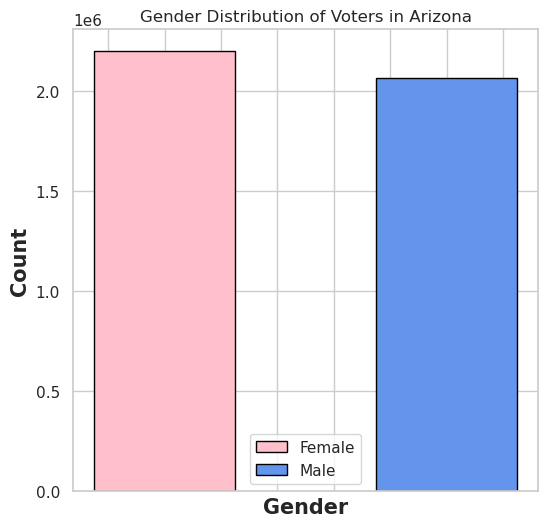

In [27]:
barWidth = 0.125
fig = plt.subplots(figsize =(6, 6))
 
# set height of bar
Fe = num[0]
M = num[1]
 
# Set position of bar on X axis
br1 = np.arange(1)
br2 = [x + 2*barWidth for x in br1]
 
# Make the plot
plt.bar(br1, Fe, color ='pink', width = barWidth,
        edgecolor ='black', label ='Female')
plt.bar(br2, M, color ='cornflowerblue', width = barWidth,
        edgecolor ='black', label ='Male')
 
# no xticks
plt.xticks(visible = False)
plt.xlabel('Gender', fontweight ='bold', fontsize = 15)
plt.ylabel('Count', fontweight ='bold', fontsize = 15)
plt.title('Gender Distribution of Voters in Arizona')
plt.legend()
plt.show()

Here, we see that for the gender distribution of voters in Arizona, the number of female voters is greater than male voters.

## Ethnic Demographics

To begin our analysis of ethnic demographics in Arizona, we first examine the top 5 ethnic groups of voters. As we can see English/Welsh led the way with 33.27%.

In [28]:
group_eth = cleaned_df2.select('Ethnic_Description').groupby('Ethnic_Description').count()
types_eth = [row[0] for row in group_eth.select('Ethnic_Description').collect()]
num_eth = [row[0] for row in group_eth.select('count').collect()]

In [29]:
# Create a DataFrame from the list
ethnic_df = spark.createDataFrame(zip(types_eth, num_eth), schema=['Types', 'Count'])

# Perform operations on the DataFrame
sorted_ethnic_df = ethnic_df.orderBy('Count', ascending=False).limit(5)
highest_ethnic_df = sorted_ethnic_df.toPandas()
total_ethnic_users = ethnic_df.groupBy().sum().collect()[0][0]

highest_ethnic_df_renamed = highest_ethnic_df
 # Compute the percentage of top 5 workout type / total users
highest_ethnic_df_renamed['Percentage'] = highest_ethnic_df['Count'] \
    / total_ethnic_users * 100
print('Top 5 ethnic groups of voters in Arizona:')
highest_ethnic_df_renamed

Top 5 ethnic groups of voters in Arizona:


,Types,Count,Percentage
0,English/Welsh,1419376,33.268704
1,Hispanic,879143,20.606202
2,None,411429,9.643470
3,German,302090,7.080677
4,Irish,261896,6.138571


Next, we display a pie chart that illustrates the broader ethnic distribution of voters in Arizona. Below, we see that European and Hispanic/Portuguese ethnic groups make up the majority of voters. These two groups combined account for 84.33% of the voting population in Arizona.

In [30]:
grouped2 = cleaned_df2.select('EthnicGroups_EthnicGroup1Desc').groupby('EthnicGroups_EthnicGroup1Desc').count()
eth = [row[0] for row in grouped2.select('EthnicGroups_EthnicGroup1Desc').collect()]
num2 = [row[0] for row in grouped2.select('count').collect()]

In [31]:
eth = [x if x is not None else 'None' for x in eth]

Text(0.5, 1.0, 'Distribution of Arizona Voters who Specified Ethnicity')

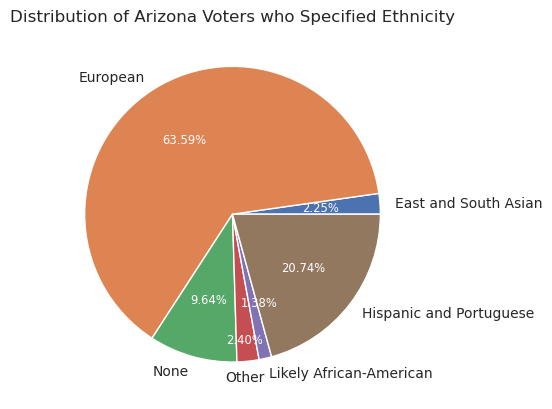

In [32]:
fig, ax = plt.subplots()
patches, texts, autotexts = ax.pie(num2, labels=eth,
                                           autopct='%.2f%%',
                                           textprops={'size': 'smaller'})

# Manually adjust the label distance for the 'Other' label
texts[3].set_position((-0.05, -1.1))  # Adjust the position (x, y) here
autotexts[3].set_position((0.08, -0.85))
autotexts[4].set_position((0.18, -0.6))
                                       
# Make percent texts even smaller
plt.setp(autotexts, size='x-small')
autotexts[0].set_color('white')
autotexts[1].set_color('white')
autotexts[2].set_color('white')
autotexts[3].set_color('white')
autotexts[4].set_color('white')
autotexts[5].set_color('white')
plt.title('Distribution of Arizona Voters who Specified Ethnicity')

## Age Distribution of Voters

Now we will explore the age distribution of voters in Arizona. The histogram reveals that the largest voter groups by age are young voters (20-30) and old voters (60-70). Additionally, the distribution of voters appears to be modestly bi-modal, with peaks in the young and old age groups.

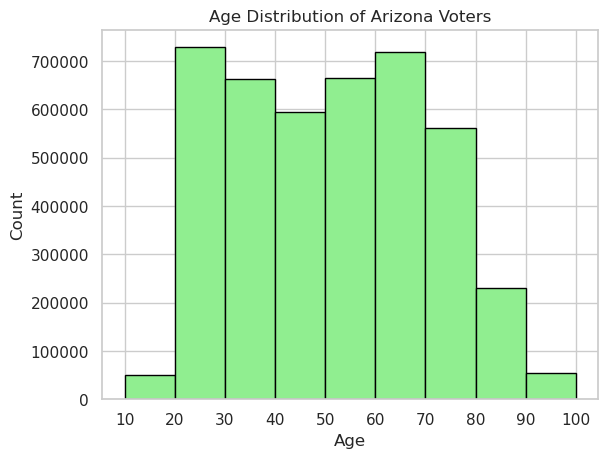

In [33]:
# Convert age data to integers
age = cleaned_df2.na.drop(subset=["Voters_Age"]).select('Voters_Age').toPandas()['Voters_Age'].astype(int)

# Define the bin edges
bins = np.arange(10, 101, 10)

plt.hist(age, bins=bins, color='lightgreen', edgecolor='black')
plt.xticks(bins)  # Set x-axis ticks to the bin edges
plt.title('Age Distribution of Arizona Voters')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

## Household Income Distribution 

Below, we compare the income distribution of Arizona voters. We observe that the largest voter groups fall within the income brackets of 50,000-74999 and 75000-99999. It is important to note that the income bracket ranges are not uniform, so comparisons should be made with caution. For instance, the bar heights for the income brackets of 125000-149999 and 35000-49999 may appear almost equal in height, but the range in income is different (25000 to 15000), which can affect how accurately we interpret the household income distribution in Arizona.

In [34]:
hhi = cleaned_df2.na.drop(subset=["CommercialData_EstimatedHHIncome"]).select("CommercialData_EstimatedHHIncome").groupby("CommercialData_EstimatedHHIncome").count().toPandas()

In [35]:
# Define the income categories and their counts
income_categories = ['$1000-14999', '$15000-24999', '$25000-34999', '$35000-49999',
                      '$50000-74999', '$75000-99999', '$100000-124999', '$125000-149999',
                      '$150000-174999', '$175000-199999', '$200000-249999', '$250000+']
counts = [111228, 123195, 231153, 486756, 1052283, 848714, 501114, 342458, 146562, 126371, 110807, 155685]

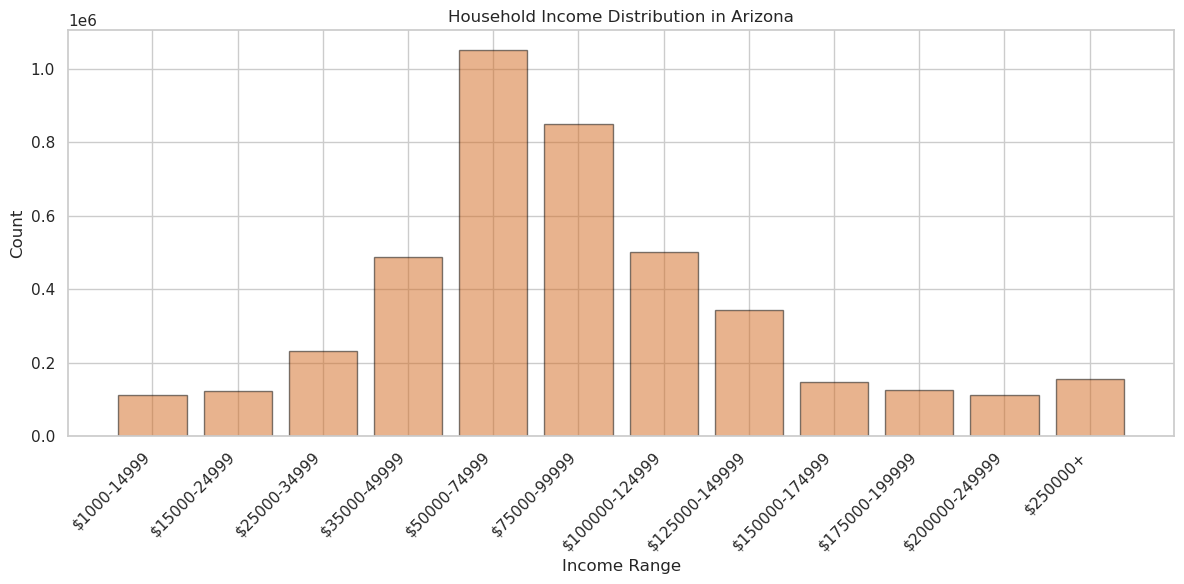

In [36]:
# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(income_categories, counts, color='chocolate', alpha = 0.5, edgecolor='black')
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Household Income Distribution in Arizona')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()

Lastly, we examine the estimated home value in Arizona. Below, we see the density plot depicting the home value distribution for voters. From the plot, we notice that the mean home value for voters in Arizona is around 300000.

In [37]:
from pyspark.sql.functions import expr
home_value_df = cleaned_df2.select("CommercialData_EstHomeValue").na.drop()\
.withColumn("HomeValue_Converted", expr("substring(CommercialData_EstHomeValue, 2, length(CommercialData_EstHomeValue))"))\
.toPandas()
home_value_df['HomeValue_Converted'] = home_value_df['HomeValue_Converted'].astype('int')


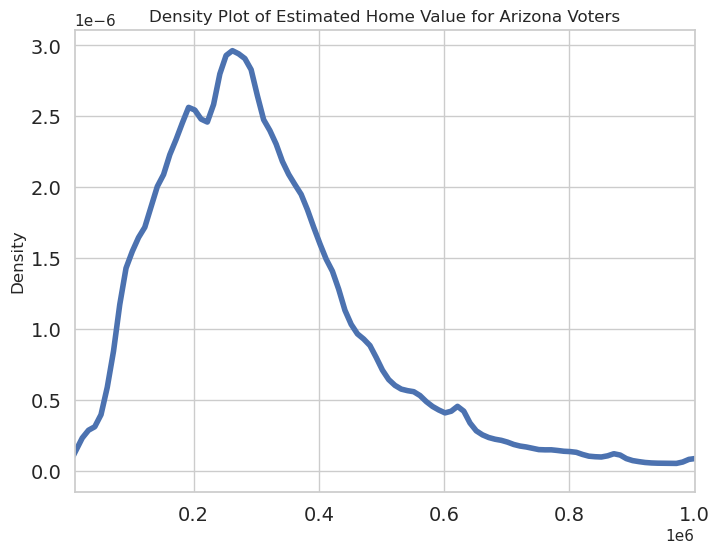

In [38]:
#density plot for home_value_converted
home_value_df.HomeValue_Converted.plot.density(figsize=(8,6),
                              fontsize=14,
                              xlim=(10000,1e6),
                              linewidth=4)
plt.title('Density Plot of Estimated Home Value for Arizona Voters')
plt.show()
